# Init

In [1]:
import os
import operator
import csv
import json
import datetime as dt
import numpy as np
import pandas as pd
import math
import random
import scipy

from sklearn.preprocessing import normalize
from scipy.optimize import minimize

## Plotting

In [2]:
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.patheffects as path_effects

import seaborn as sns

In [3]:
plt.rcParams["font.family"] = 'Courier'
%matplotlib inline

In [4]:
set([f.name for f in matplotlib.font_manager.fontManager.afmlist])

{'Computer Modern',
 'Courier',
 'Helvetica',
 'ITC Avant Garde Gothic',
 'ITC Bookman',
 'ITC Zapf Chancery',
 'ITC Zapf Dingbats',
 'New Century Schoolbook',
 'Palatino',
 'Symbol',
 'Times',
 'Utopia',
 'ZapfDingbats'}

## Original run settings

In [5]:
year_series = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [6]:
data_procecing_run = '19-ext'
number_of_topics = 22
original_run_prefix = 'run_%s_%s' % (data_procecing_run, number_of_topics)

## Paths

In [7]:
PATHS = {}

PATHS['root'] = os.path.join('..')
PATHS['tickers'] = os.path.join(PATHS['root'], 'data_processing', 'tickers')
PATHS['original_run'] = os.path.join(PATHS['root'], 'data_runs', original_run_prefix)
PATHS['original_dtm_results'] = os.path.join(PATHS['original_run'], 'results', 'lda-seq')
PATHS['original_run_interpretation'] = os.path.join(PATHS['original_run'], 'interpretation')
PATHS['original_run_returns'] = os.path.join(PATHS['original_run_interpretation'], 'return')
PATHS['runs_n-1'] = os.path.join(PATHS['root'], 'data_n-1_experiment')


PATHS['src'] = os.path.join(PATHS['root'], 'src')



In [8]:
FILES = {}
FILES['return_coeficients'] = os.path.join(PATHS['original_run'], '%s-returns.csv' % original_run_prefix)
FILES['tickers'] = os.path.join(PATHS['tickers'], 'ticker_for_analysis.csv')
FILES['tickers_names'] = os.path.join(PATHS['tickers'], 'tickers_names_map.csv')


In [9]:
import sys

sys.path.insert(0, PATHS['src'])
print(sys.path)

['../src', '/Users/Alan_Spark/Projects/research/dtm-reports-analysis/notebooks', '/Users/Alan_Spark/Projects/tensorflow/models/research', '/Users/Alan_Spark/Projects/research/dtm-reports-analysis/notebooks', '/Users/Alan_Spark/opt/anaconda3/lib/python37.zip', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/Alan_Spark/.ipython']


## Flags 

In [10]:
FLAGS = {}
FLAGS['plot monochrome'] = False

# Get top words original run

In [11]:
top_words = [
    'chase, mortgage, collar',
    'reinsurance, casualty, policyholder',
    'electricity, semiconductor, renewable',
    'passenger, aircraft, air',
    'medical, patient, hospital',
    'registration, subscription, client',
    'mine, mining, copper',
    'hotel, restaurant, store',
    'mobile, wireless, spectrum topic',
    'sky, television, client',
    'steel, elevator, condense',
    'salt, cloud, subscription',
    'store, food, coca_cola',
    'patent, pharmaceutical, patient topic',
    'mail, air, engineering',
    'client, mortgage, tier',
    'aircraft, defence, engineering topic',
    'car, truck, automotive',
    'electricity, nuclear, coal',
    'agent, lender, exhibit',
    'store, cosmetic, digital',
    'appointment, taxation, skill',
]

# Get comanies names

In [12]:
companies_names = {}

with open(FILES['tickers_names'], 'r') as f_r:
    for t_l in f_r:
        o = t_l.strip().split(',')
        companies_names[o[0]] = o[1]

# Get returns for original run

In [13]:
df_original_returns = None

with open(os.path.join(PATHS['original_run_returns'], 'results-returns_dataframe.csv'), 'r') as f_r:
    df_original_returns = pd.read_csv(f_r);
    df_original_returns['Date'] = pd.to_datetime(df_original_returns['Date'])
    df_original_returns.set_index('Date', inplace=True)

In [14]:
df_original_returns.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2006-01-02,0.999994,1.000014,1.000006,1.000002,1.000000,0.999990,0.999705,1.000016,1.000007,1.000010,...,1.000028,1.000005,0.999994,1.000013,1.000030,0.999995,1.000006,1.000036,1.000005,0.999931
2006-01-03,0.999956,1.001051,1.006892,1.009774,1.019162,1.003334,1.001591,1.008271,1.000691,0.999975,...,1.000856,1.003795,1.000747,1.000349,1.003587,0.995977,1.001330,0.998331,0.991825,0.998108
2006-01-04,0.989181,1.007496,1.029628,1.018380,1.033782,1.020632,1.015992,1.017121,1.020185,0.992228,...,0.991446,1.015850,1.002093,1.003111,1.002552,1.003371,1.010700,0.995247,0.985809,1.008842
2006-01-05,0.993080,1.002336,1.059555,1.011840,1.025772,1.047769,1.001834,0.999875,1.026697,0.997197,...,0.984958,1.013302,0.991583,1.003224,0.999332,1.004462,1.003970,1.000345,0.985935,1.000883


In [15]:
from investment_ops.returns import get_return_on_investment, get_final_return

In [16]:
original_run_returns = get_final_return(returns=df_original_returns,
                                        number_of_topics=number_of_topics)
    
for topic_id in range(number_of_topics):
    print('Topic %s return: %s' % (topic_id, original_run_returns[topic_id]))

Topic 0 return: 3.4182875613667534
Topic 1 return: 5.262106052734815
Topic 2 return: 4.16189886940559
Topic 3 return: 0.3678590051569448
Topic 4 return: 3.066193551086726
Topic 5 return: 4.251398870627972
Topic 6 return: 8.115442410954518
Topic 7 return: 4.5652819069139605
Topic 8 return: 3.023016594907041
Topic 9 return: 4.19135356292634
Topic 10 return: 7.512898185157755
Topic 11 return: 3.7748049477656656
Topic 12 return: 2.7349215742068926
Topic 13 return: 12.646284985575448
Topic 14 return: 6.708171499251321
Topic 15 return: 0.3943443722155679
Topic 16 return: 1.8250940869165
Topic 17 return: 2.933762067473401
Topic 18 return: 1.3757629924508394
Topic 19 return: 23.634873182367784
Topic 20 return: 8.642810109995782
Topic 21 return: 4.168328859747342


# Get returns for "n-1" experiment

In [17]:
from ticker_ops.tickers_io import get_tickers
from dtm_ops.dtm_results import get_reports, get_gammas, aggregate_gammas
from investment_ops.weights import get_weights
from investment_ops.returns import get_return_on_investment

In [18]:
all_tickers = get_tickers(FILES['tickers'])

print('%s tickers are availabl' % len(all_tickers))

79 tickers are availabl


In [19]:
def weights_min_max(weights = {}):
    t_min = 0
    t_max = 0
    for year in weights:
        year_weights = weights[year]
        for ticker in year_weights:
            posible_min = min(year_weights[ticker])
            t_min = posible_min if posible_min < t_min else t_min
            posible_max = max(year_weights[ticker])
            t_max = posible_max if posible_max > t_max else t_max
    
    return {
        'min': t_min,
        'max': t_max
    }

In [20]:
def get_return_delta(base_return, run_return):
    delta = []
    for topic_id in range(number_of_topics):
        diff = run_return[topic_id] - base_return[topic_id]
        #percentage = (diff / base_return[topic_id]) * 100
        delta.append(diff)
        
    
    return delta

In [21]:
def get_run_return(ticker, tickers_in_order, t):
    dtm_path=os.path.join(PATHS['runs_n-1'], 'run-%s' % ticker)
    reports = get_reports(dtm_path=dtm_path, run_prefix = 'run-%s' % ticker)
    reports_gammas = get_gammas(
        reports=reports,
        dtm_path=dtm_path,
        number_of_topics=number_of_topics,
        weght_by_report_length=True)
    ticker_gammas = aggregate_gammas(gammas=reports_gammas, reports=reports)
    weights = get_weights(
        gammas=ticker_gammas,
        tickers=tickers_in_order,
        number_of_topics = t,
        bounds = (-1,2))
    
    weights_mm = weights_min_max(weights)
    print('%s min: %s max: %s' % (ticker, weights_mm['min'], weights_mm['max']))
    
    roi = get_return_on_investment(
        path_return_coeficients=FILES['return_coeficients'],
        weights=weights,
        tickers=tickers_in_order,
        number_of_topics = t,
        year_series=year_series,#todo improve -> global value
        initial_amount_to_invest = 1)
    last_day_returns = get_final_return(
        returns=roi,
        number_of_topics=t)
    
    #print('Returns for %s' % ticker)
    #print(last_day_returns)
    
    return last_day_returns

In [22]:
returns = {}
max_i = 100
i = 0
for ticker in all_tickers:
    ticker_deducted = [x for x in all_tickers if x != ticker]
    run_return = get_run_return(ticker, ticker_deducted, number_of_topics)
    returns[ticker] = get_return_delta(original_run_returns, run_return)
    i += 1
    if i > max_i:
        break

AAL_FTSE min: -0.9948270198447658 max: 1.9279910689716815
ACA_CAC min: -0.988436270960123 max: 1.9312442699626402
AC_CAC min: -0.9298905197165143 max: 1.8667352190529662
ADM_FTSE min: -0.9995191659391776 max: 1.9282829228218685
AGK_FTSE min: -0.9966327500922103 max: 1.9245479140463209
AIR_CAC min: -0.9774246432479448 max: 1.9128530678951152
ALV_DAX min: -0.9719825428748237 max: 1.9216156624348995
ANTO_FTSE min: -0.9767994017949106 max: 1.9213963426503935
BAB_FTSE min: -0.9427633294117279 max: 1.919147194643933
BARC_FTSE min: -0.9987936936104536 max: 1.9525418945115345
BAYN_DAX min: -0.9975962384645196 max: 1.9571872370468386
BA_FTSE min: -0.9795997772735902 max: 1.9036488066396962
BMW_DAX min: -0.9807175145585375 max: 1.9219387097515317
BNP_CAC min: -0.9762092703768964 max: 1.918881518095897
CAP_CAC min: -0.9982033406900086 max: 1.9191938156452044
CBK_DAX min: -0.9914922585164988 max: 1.9263792705722966
CSCO_DJIA min: -0.9973769283092632 max: 1.8685977222129435
CS_CAC min: -0.935689317

# Visualisation

## returns deltas to df

In [23]:
columns = ['Topic %s' % i for i in range(number_of_topics)]
df_deltas = pd.DataFrame.from_dict(returns, orient='index', columns = columns)

df_deltas.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21
AAL_FTSE,2.483224,-0.853095,-0.386663,0.008421,0.076866,0.604322,2.800752,-0.120953,0.053606,0.069366,...,0.079364,-1.378742,2.194203,-0.011228,-0.055282,-0.007840,0.007357,4.723053,-0.501170,-0.080345
ACA_CAC,0.870959,-0.632146,-0.274606,-0.000499,0.176136,3.279933,0.046851,0.176751,0.034294,0.033760,...,0.024065,-1.164954,2.291643,0.011580,-0.059733,0.068183,0.011508,-6.221415,-1.502085,0.067794
AC_CAC,4.003428,-0.872514,-0.468500,0.014129,0.089522,0.748183,0.055673,2.137436,0.117066,0.031448,...,-0.421113,-1.173669,2.228765,-0.018887,-0.004360,-0.052773,0.007026,-0.668804,-0.308412,-0.041570
ADM_FTSE,3.818082,-2.167173,-0.528959,0.009233,0.041243,0.849883,0.017990,-0.085289,0.021653,0.012874,...,0.067627,-0.995152,0.002129,-0.010544,-0.018632,0.087912,-0.004803,0.409957,-0.396825,0.052851
AGK_FTSE,2.865350,-0.857851,-0.733951,-0.028116,0.077957,0.690831,0.039606,-0.115262,0.105172,-0.000670,...,0.053985,-1.103562,2.315826,-0.008465,0.024049,-0.008693,-0.019933,-0.397459,-0.434875,-0.085391


In [24]:
indexes = list(df_deltas.index.values)
for index in indexes:
    df_deltas.rename(index={index:'%s (%s)' % (companies_names[index], index)},inplace=True)

df_deltas.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21
Anglo American (AAL_FTSE),2.483224,-0.853095,-0.386663,0.008421,0.076866,0.604322,2.800752,-0.120953,0.053606,0.069366,...,0.079364,-1.378742,2.194203,-0.011228,-0.055282,-0.007840,0.007357,4.723053,-0.501170,-0.080345
Credit Agricole (ACA_CAC),0.870959,-0.632146,-0.274606,-0.000499,0.176136,3.279933,0.046851,0.176751,0.034294,0.033760,...,0.024065,-1.164954,2.291643,0.011580,-0.059733,0.068183,0.011508,-6.221415,-1.502085,0.067794
Accor (AC_CAC),4.003428,-0.872514,-0.468500,0.014129,0.089522,0.748183,0.055673,2.137436,0.117066,0.031448,...,-0.421113,-1.173669,2.228765,-0.018887,-0.004360,-0.052773,0.007026,-0.668804,-0.308412,-0.041570
Admiral (ADM_FTSE),3.818082,-2.167173,-0.528959,0.009233,0.041243,0.849883,0.017990,-0.085289,0.021653,0.012874,...,0.067627,-0.995152,0.002129,-0.010544,-0.018632,0.087912,-0.004803,0.409957,-0.396825,0.052851
Aggreko (AGK_FTSE),2.865350,-0.857851,-0.733951,-0.028116,0.077957,0.690831,0.039606,-0.115262,0.105172,-0.000670,...,0.053985,-1.103562,2.315826,-0.008465,0.024049,-0.008693,-0.019933,-0.397459,-0.434875,-0.085391


## Visualise DF as stacked bar plot

In [25]:
colors_map = plt.cm.get_cmap('rainbow', number_of_topics)
colors_topic = [colors_map(x) for x in range(number_of_topics)]
color_north = colors_topic[4]
color_south = colors_topic[-4]

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


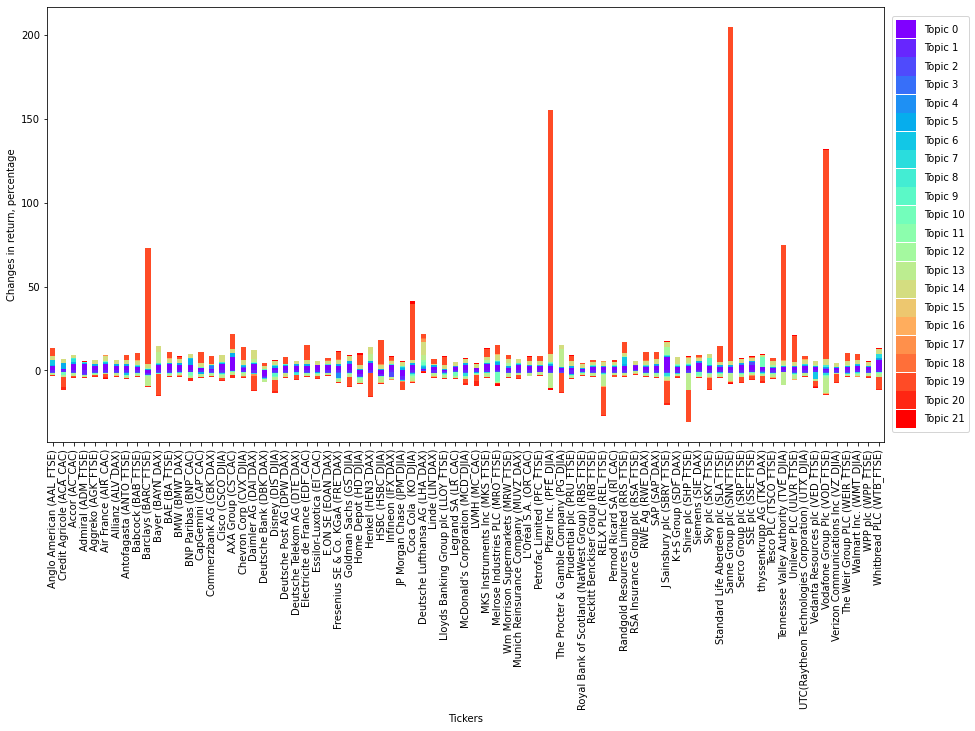

In [26]:
fig, ax = plt.subplots(
    nrows=1, 
    ncols=1,  
    figsize=(15, 8)) 


df_deltas.plot.bar(ax=ax, stacked=True, color=colors_topic)
lgd = ax.legend(bbox_to_anchor=(1.055, 0.99), loc="upper center", ncol=1, handleheight=2.4, labelspacing=0.05)

ax.set_ylabel("Changes in return, percentage")
ax.set_xlabel("Tickers")

#save plot
pp = PdfPages(os.path.join(PATHS['original_run_interpretation'], 'return_plots', 'n-1_returns_stack.pdf'))
plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
pp.close()

## Plot by pages

In [27]:
def print_deltas(df = {}, page=0, per_page=11, number_of_topics=22):
    start = page * per_page
    end = start + per_page
    
    fig, axes = plt.subplots(
    nrows=per_page, 
    ncols=1,  
    sharex=True,
    figsize=(15, 25)) 
    
    for i in range(per_page): 
        t = i + start
        if t >= number_of_topics:
            axes[i].axis('off')
            continue
            
        topic_name = 'Topic %s' % t
        colors = [color_north if x > 0 else color_south for x in df_deltas[topic_name]]
        df[topic_name].plot(ax=axes[i], kind='bar', label='index', color=colors, align='center', width=1.0);
        axes[i].set_title('%s (%s)' % (topic_name, top_words[t]));
        
        axes[i].set_ylabel("Changes in return, percentage")
        axes[i].set_xlabel("Tickers")

    #save plot
    pp = PdfPages(os.path.join(PATHS['original_run_interpretation'], 'return_plots', 'n-1_returns_page_%s.pdf' % page))
    plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    pp.close()

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


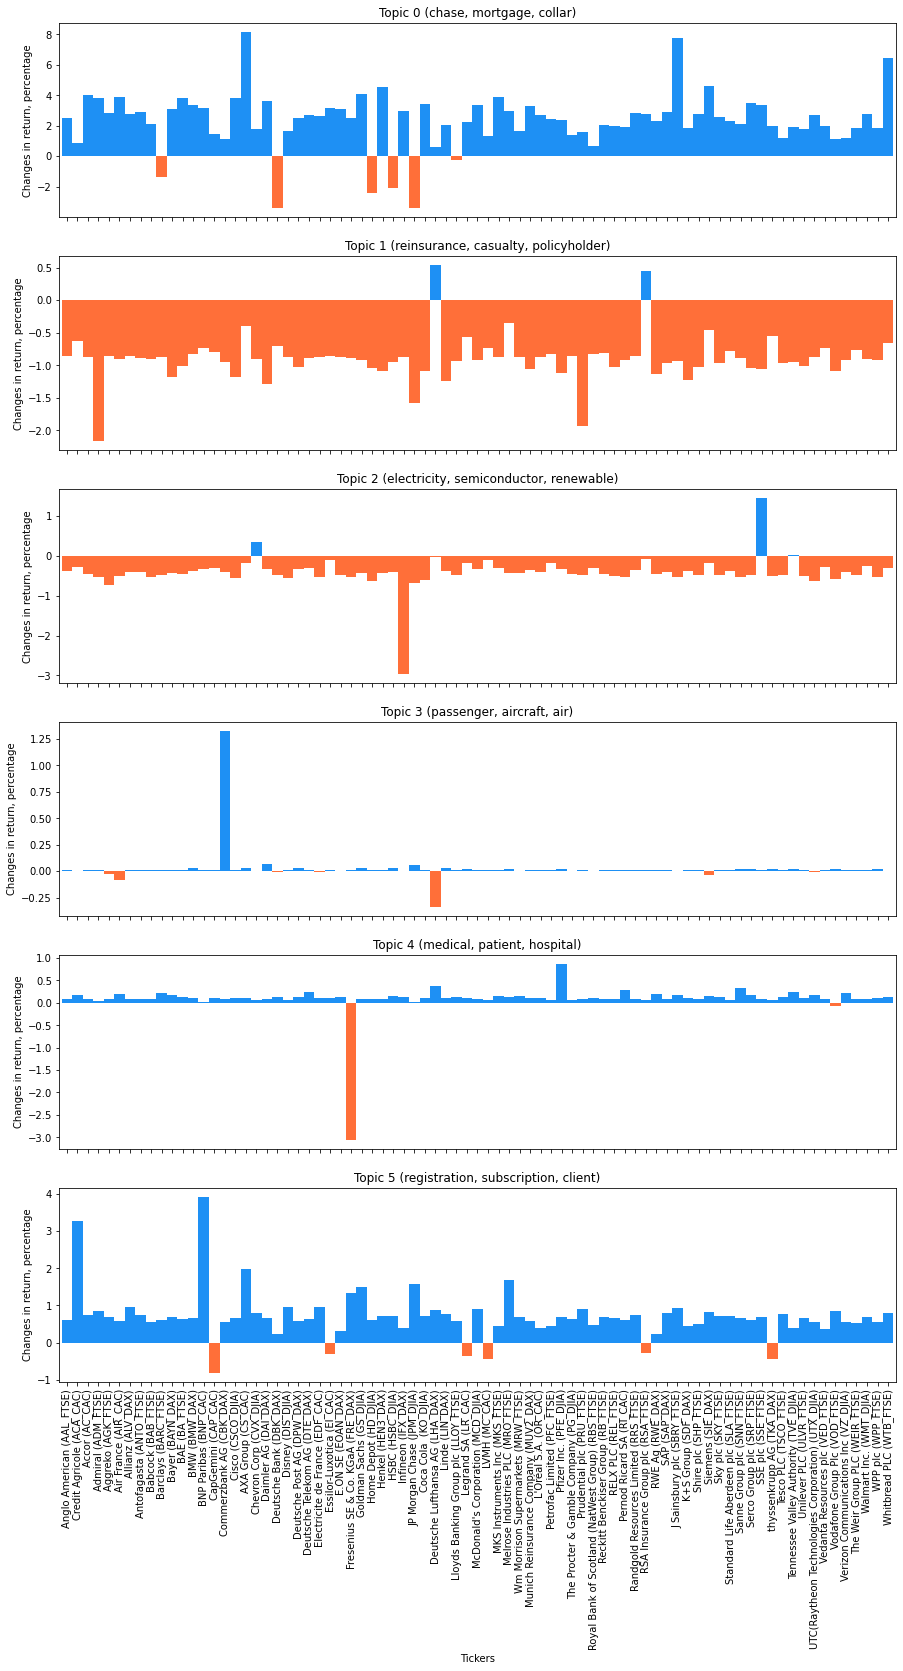

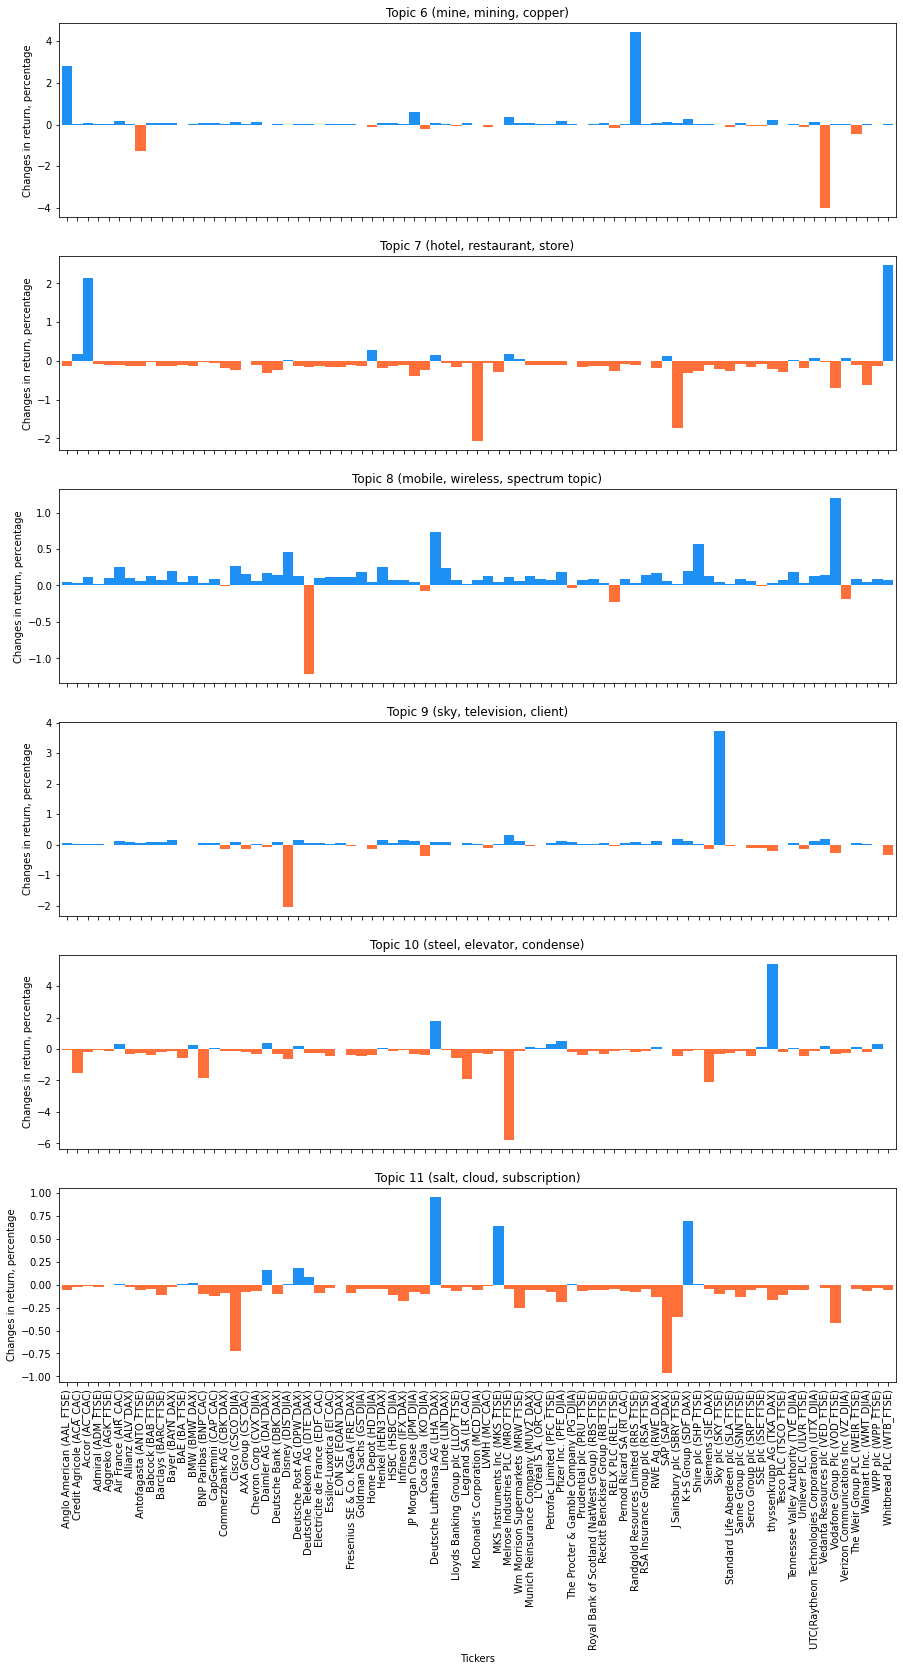

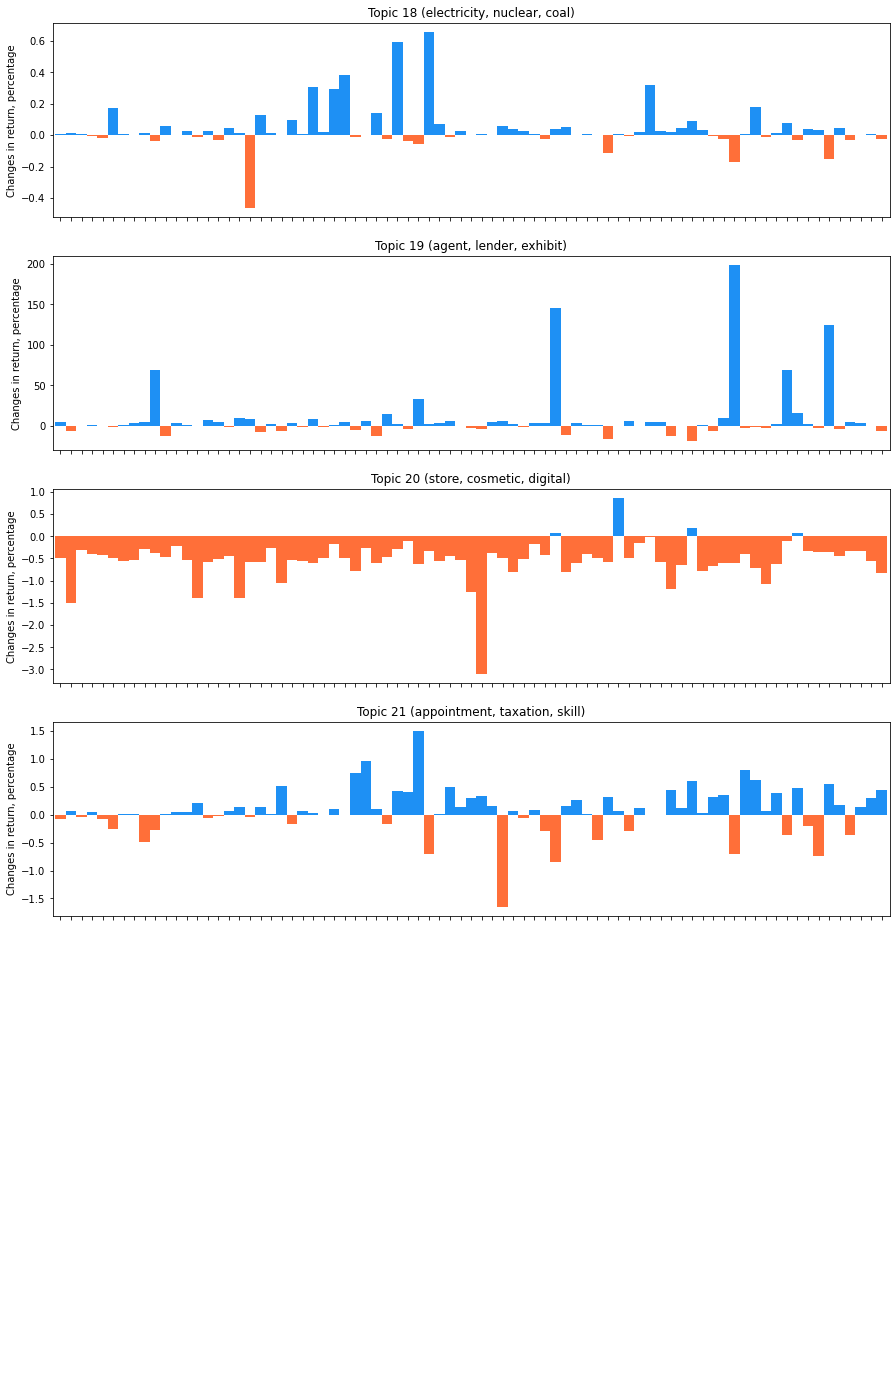

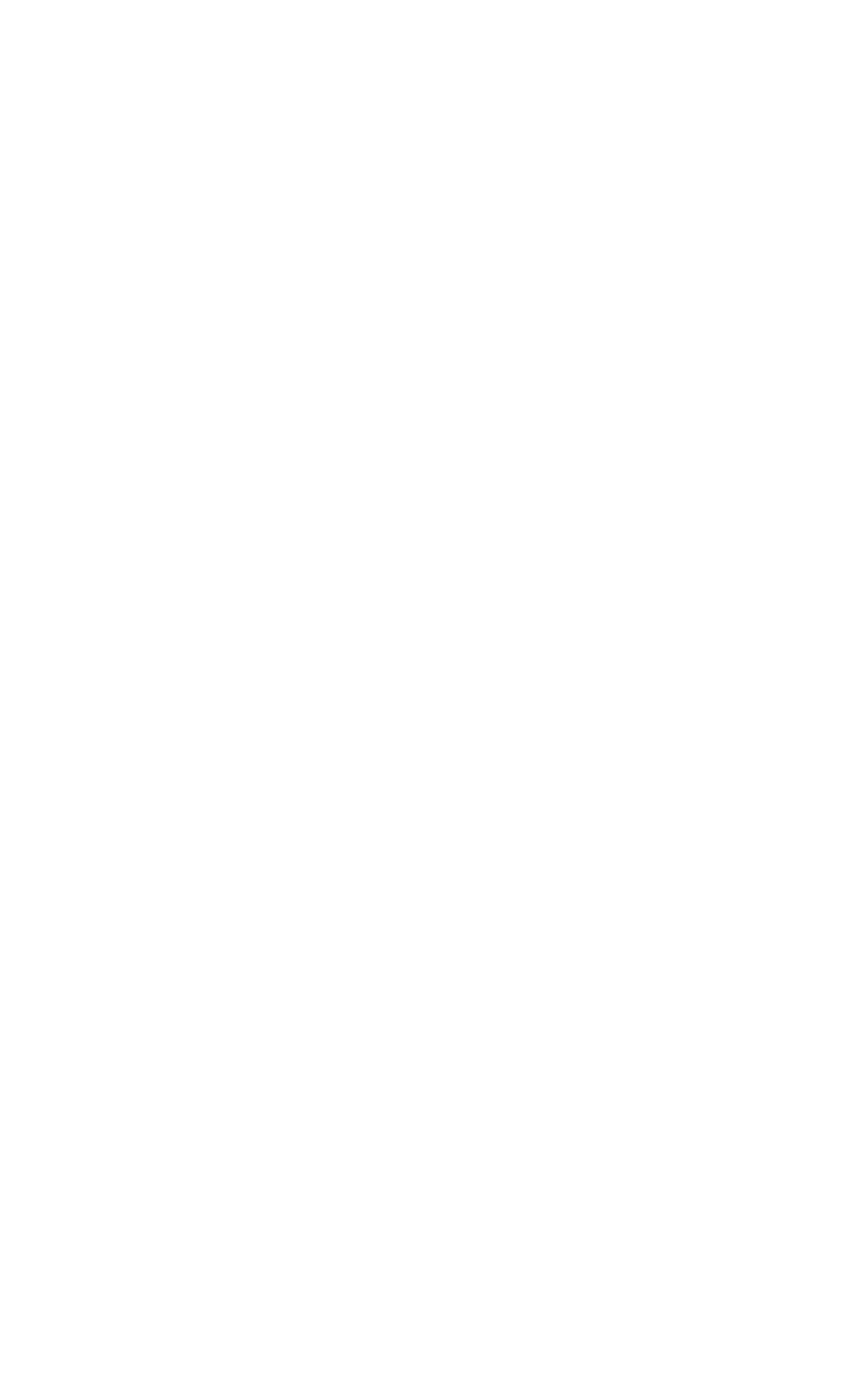

In [28]:
print_deltas(df=df_deltas, page=0, per_page=6)
print_deltas(df=df_deltas, page=1, per_page=6)
print_deltas(df=df_deltas, page=3, per_page=6)
print_deltas(df=df_deltas, page=4, per_page=6)
